In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
credit= pd.read_csv('../data/german_credit_data.csv')
credit.head()

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
credit.select_dtypes(exclude='O').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Age           1000 non-null   int64
 1   Job           1000 non-null   int64
 2   CreditAmount  1000 non-null   int64
 3   Duration      1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


In [ ]:
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Credit amount variable has a high std as expected. Duration and Age have similar, and job, being a discrete variable, has a low dispertion.

In [4]:
sns.set()
plt.rcParams["figure.figsize"]= (10, 6)

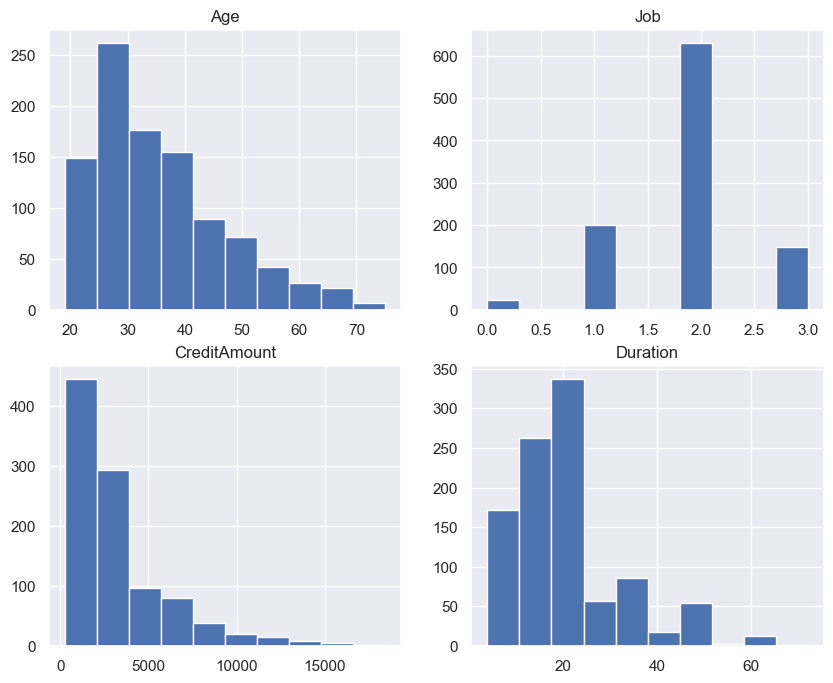

In [5]:
numerical_data= credit.select_dtypes(exclude='O')
plt.figure(figsize=(10, 8))
k=0
cols= numerical_data.columns
for i, j in zip(range(len(cols)), cols):
    k+=1
    plt.subplot(2,2,k)
    plt.hist(numerical_data.iloc[:, i])
    plt.title(j)

None of these variables follow a normal distribution. Aside from job(discrete), all the other have a skewed distribution. 

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [7]:
scaler= StandardScaler()
scaled_credit= scaler.fit_transform(numerical_data)

In [8]:
distance= []
for k in range(1, 10):
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(scaled_credit)
    distance.append(kmeans.inertia_)

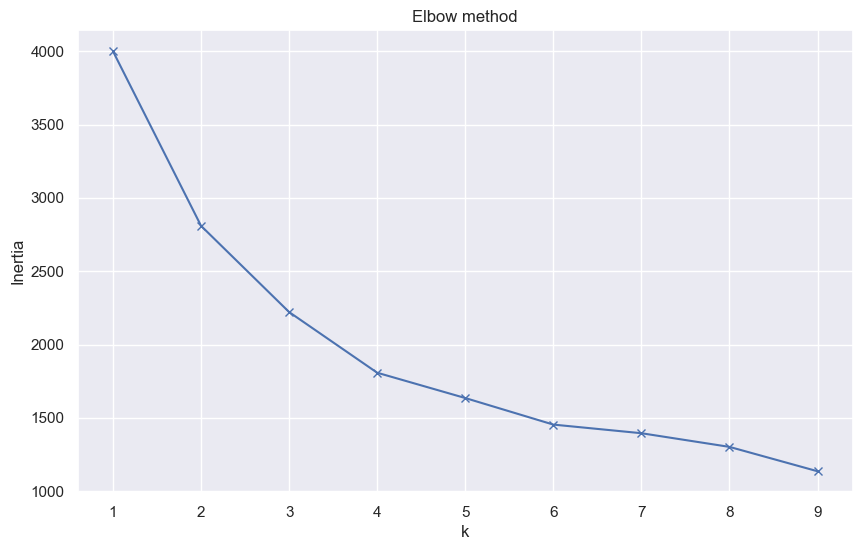

In [9]:
plt.plot(range(1,10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

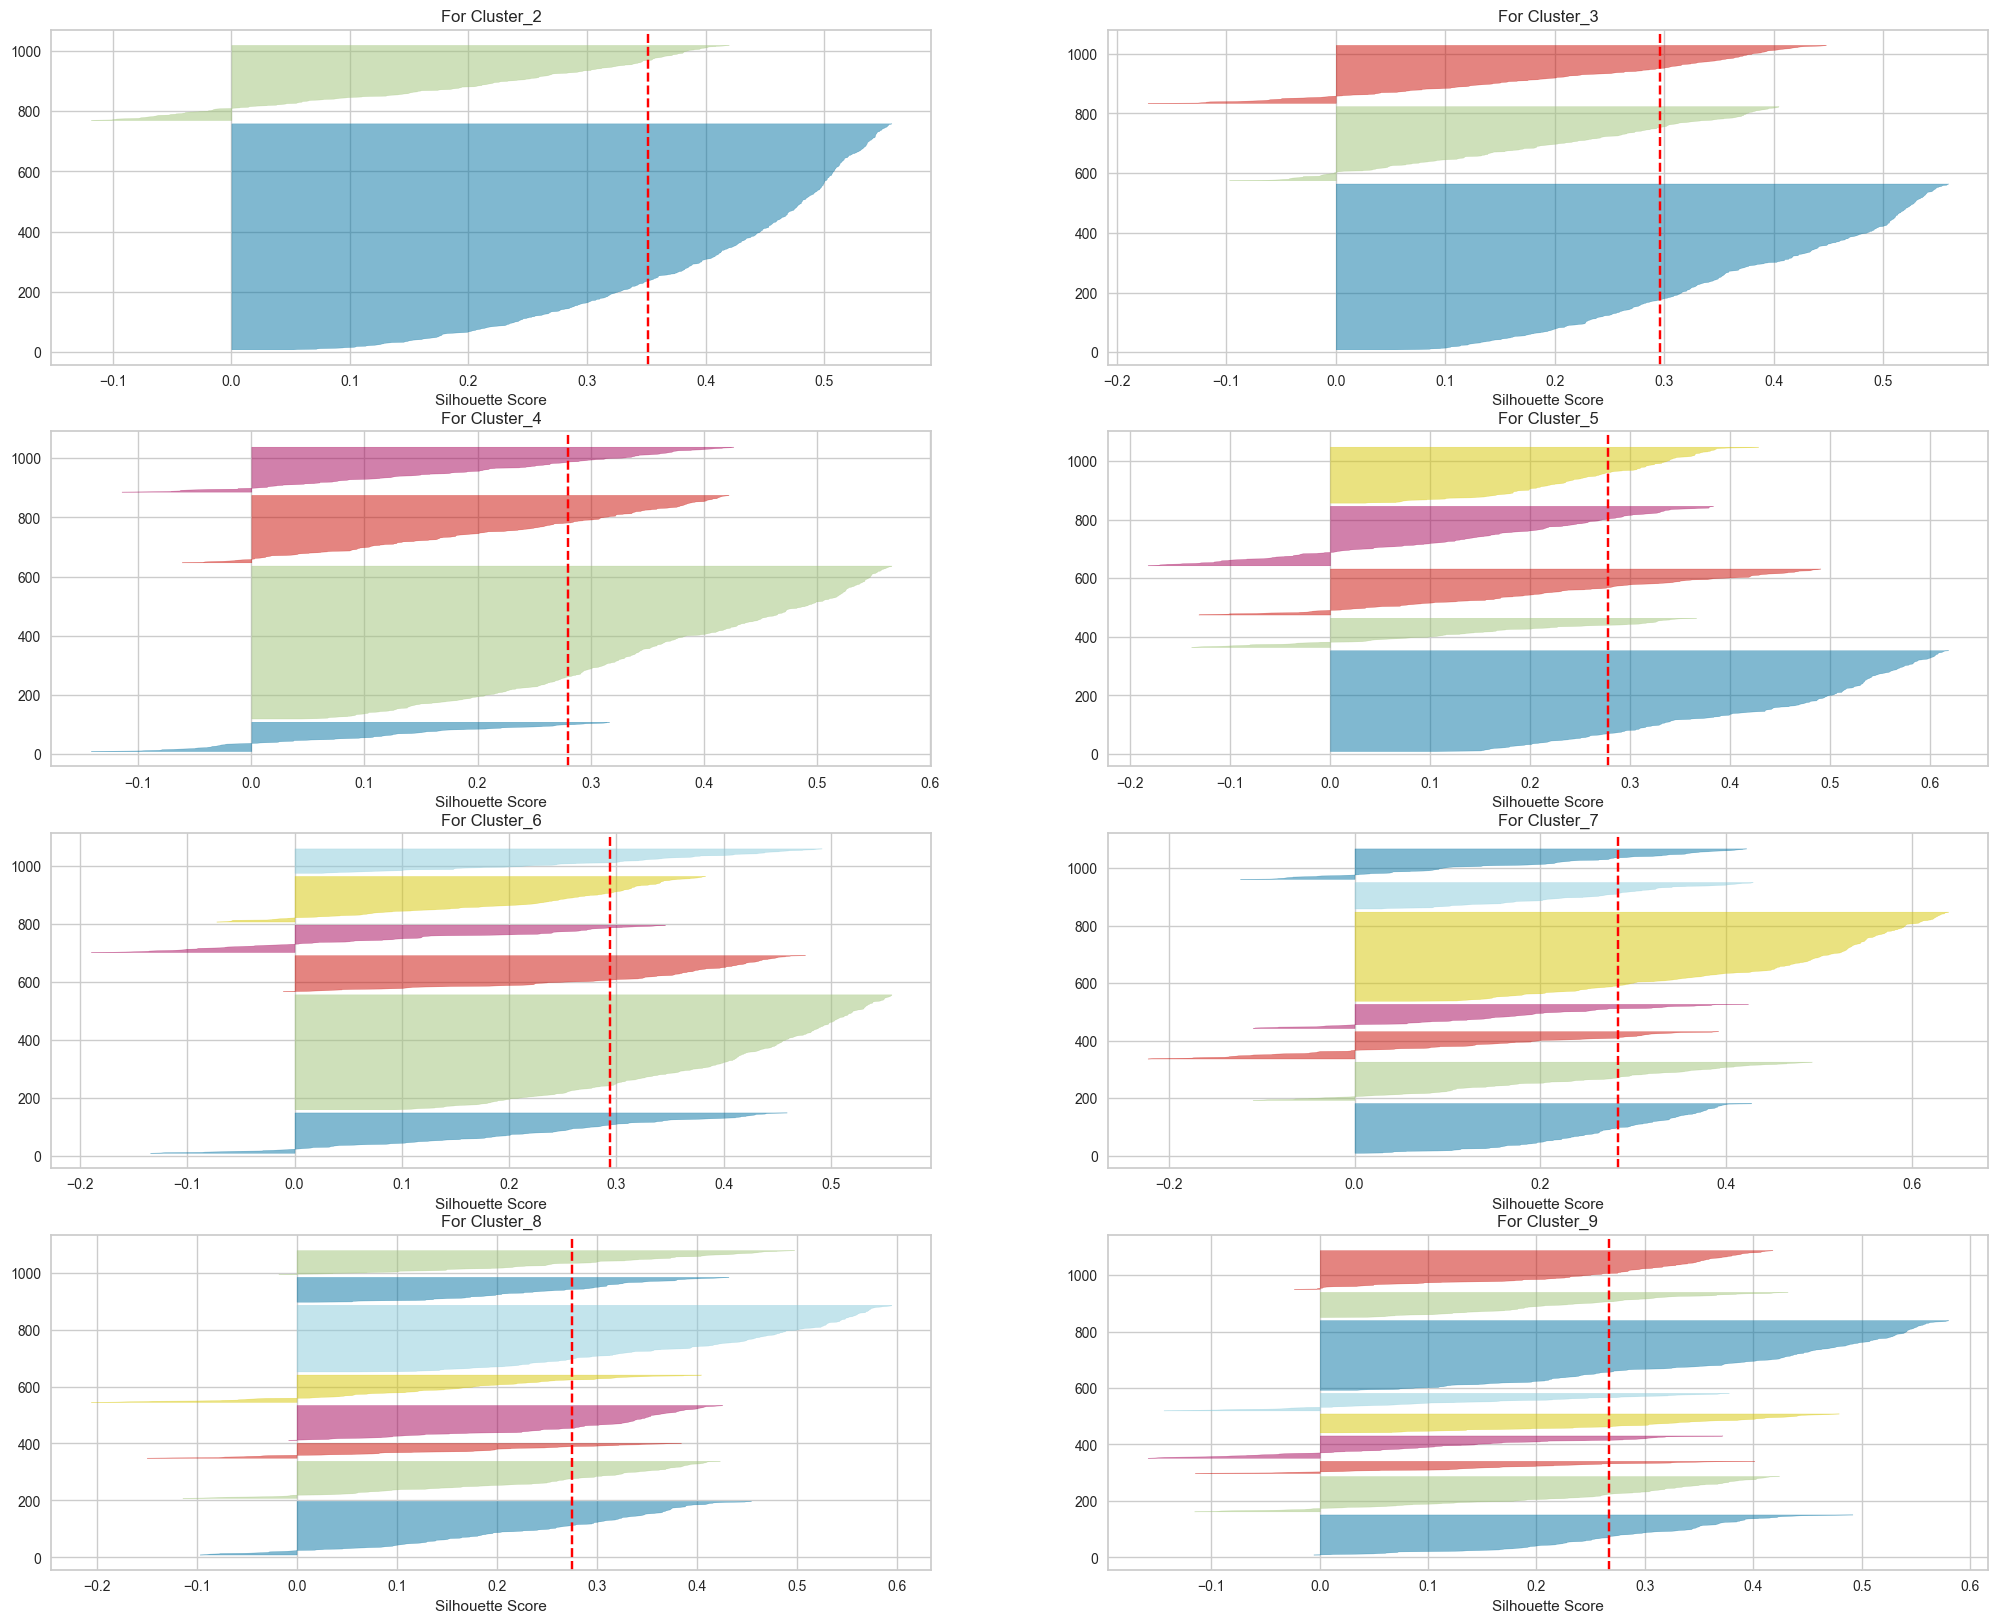

In [10]:
#Silhouette scores for clusters 2-10
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax= plt.subplots(4,2, figsize=(25, 20))
for i in range(2, 10):
    km= KMeans(n_clusters=i)
    q, r= divmod(i, 2)
    visualizer= SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][r])
    visualizer.fit(scaled_credit)
    ax[q-1][r].set_title("For Cluster_"+str(i))
    ax[q-1][r].set_xlabel("Silhouette Score")

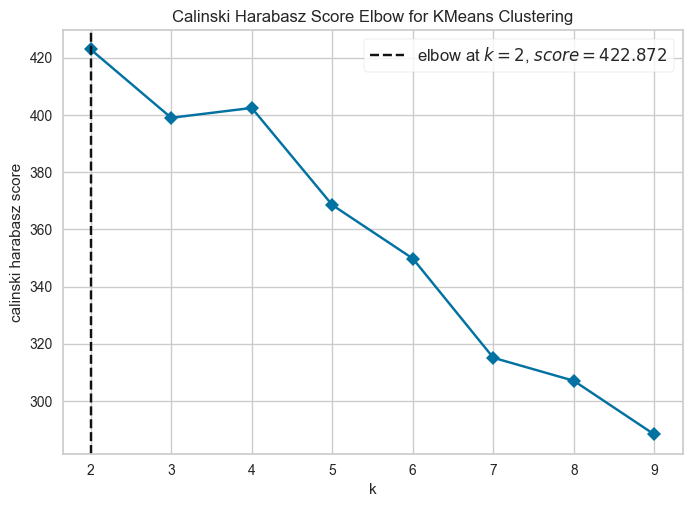

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [11]:
#CH method
from yellowbrick.cluster import KElbowVisualizer
model= KMeans()
visualizer= KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz', timings=False)
visualizer.fit(scaled_credit)
visualizer.show()

In [12]:
kmeans= KMeans(n_clusters=2)
clusters= kmeans.fit_predict(scaled_credit)

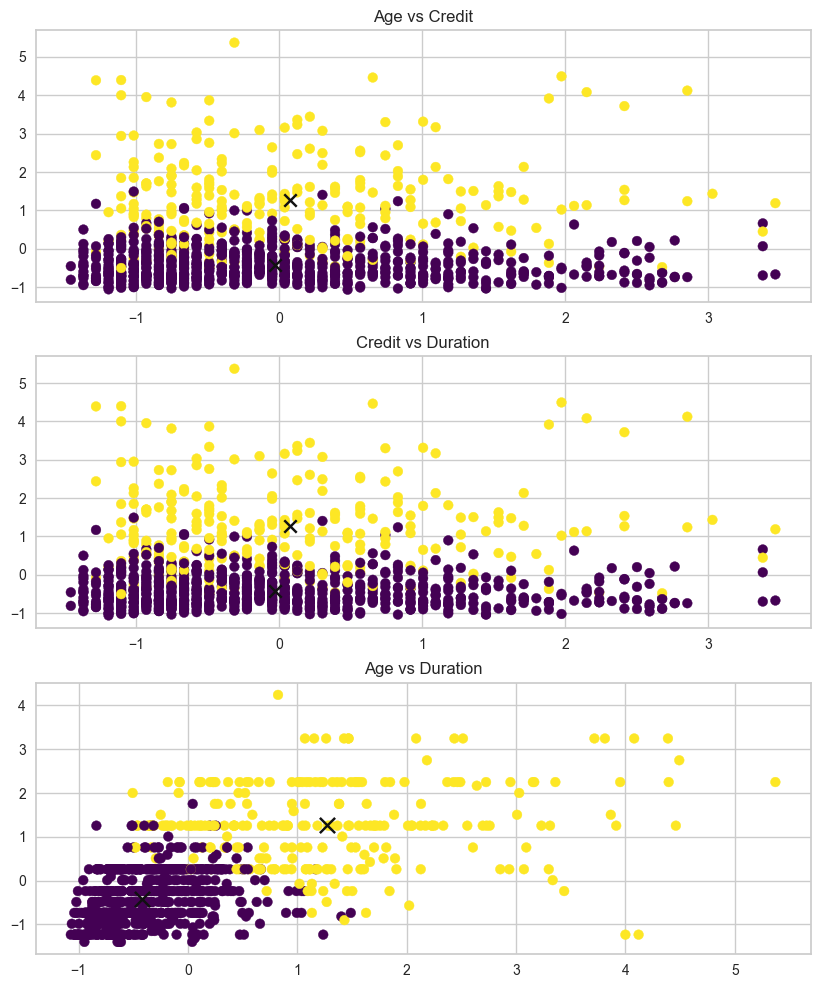

In [13]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],
                     c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],
                     kmeans.cluster_centers_[:, 2], s = 80,
                     marker= 'x', color = 'k')
plt.title('Age vs Credit')
plt.subplot(312)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2],c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s = 80,
                     marker= 'x', color = 'k')
plt.title('Credit vs Duration')
plt.subplot(313)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 3],c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 2],kmeans.cluster_centers_[:, 3], s = 120,
                     marker= 'x', color = 'k')
plt.title('Age vs Duration')
plt.show()

Probability of default with Logistic Regression

In [14]:
clusters, counts= np.unique(kmeans.labels_, return_counts=True)

In [15]:
cluster_dict= {}
for i in range(len(clusters)):
    cluster_dict[i]= scaled_credit[np.where(kmeans.labels_==i)]

In [16]:
credit['clusters']= pd.DataFrame(kmeans.labels_)

In [17]:
df_scaled= pd.DataFrame(scaled_credit)
df_scaled['clusters']= credit['clusters']

In [18]:
df_scaled['Risk']= credit['Risk']

In [19]:
df_scaled.columns= ['Age', 'Job', 'Credit amount', 'Duration', 'Clusters', 'Risk']

In [20]:
df_scaled[df_scaled.Clusters==0]['Risk'].value_counts()

Risk
good    561
bad     190
Name: count, dtype: int64

In [21]:
df_scaled[df_scaled.Clusters==1]['Risk'].value_counts()

Risk
good    139
bad     110
Name: count, dtype: int64

<Axes: title={'center': 'Frequency of Risk Level'}, xlabel='Risk'>

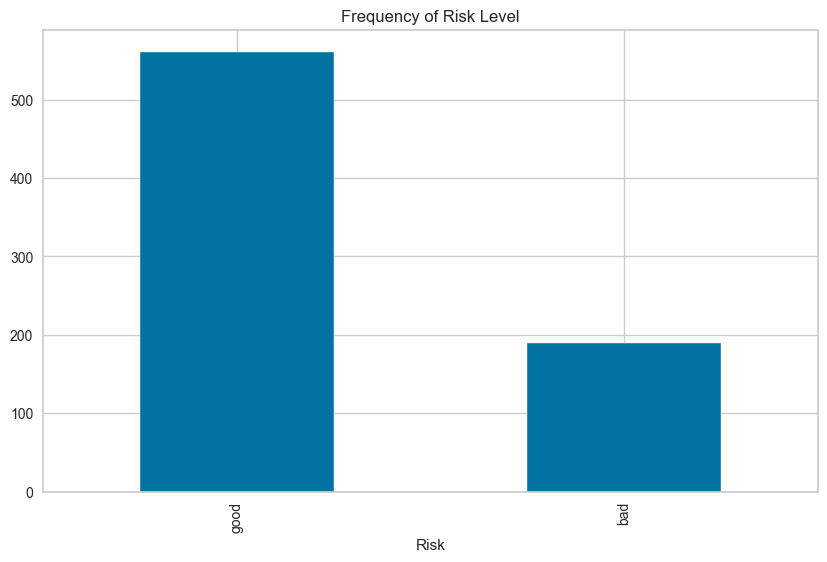

In [22]:
df_scaled[df_scaled.Clusters == 0]['Risk'].value_counts().plot(kind='bar', figsize=(10, 6),
                                             title="Frequency of Risk Level")

<Axes: title={'center': 'Frequency of Risk Level'}, xlabel='Risk'>

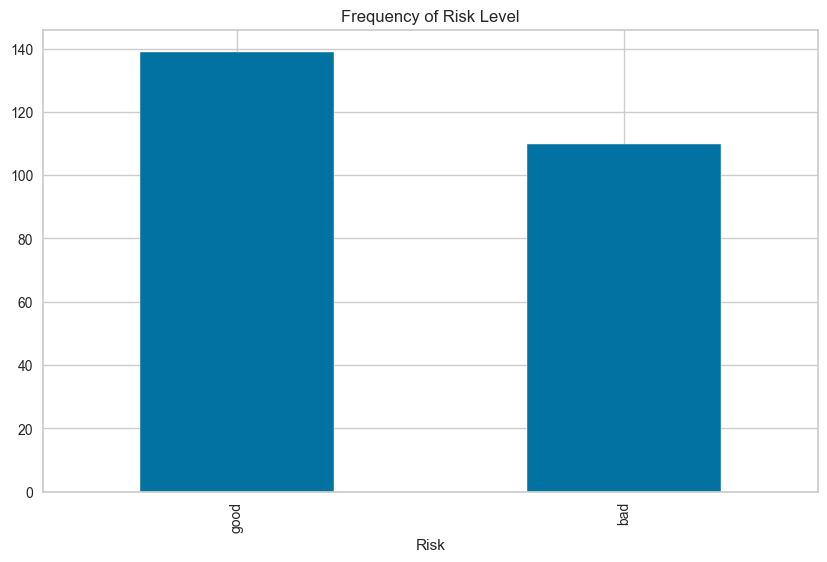

In [23]:
df_scaled[df_scaled.Clusters == 1]['Risk'].value_counts()\
                                             .plot(kind='bar',
                                             figsize=(10, 6),
                                             title="Frequency of Risk Level")

In [24]:
from sklearn.model_selection import train_test_split
df_scaled['Risk']= df_scaled['Risk'].replace({'good':1, 'bad':0})

C:\Users\mwang\AppData\Local\Temp\ipykernel_15280\957730159.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_scaled['Risk']= df_scaled['Risk'].replace({'good':1, 'bad':0})


In [25]:
X= df_scaled.drop('Risk', axis=1)
y= df_scaled.loc[:, ['Risk', 'Clusters']]

In [26]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
first_cluster_train= X_train[X_train.Clusters==0].iloc[:, :-1]
second_cluster_train= X_train[X_train.Clusters==1].iloc[:, :-1]

In [28]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN 
import warnings
warnings.filterwarnings('ignore')

In [29]:
X_train1= first_cluster_train
y_train1= y_train[y_train.Clusters==0]['Risk']
smote= SMOTEENN(random_state=42)
X_train1, y_train1=smote.fit_resample(X_train1, y_train1.ravel())
logit= sm.Logit(y_train1, X_train1)
logit_fit1= logit.fit()
print(logit_fit1.summary())

Optimization terminated successfully.
         Current function value: 0.436227
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  393
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.3652
Time:                        09:38:55   Log-Likelihood:                -171.44
converged:                       True   LL-Null:                       -270.05
Covariance Type:            nonrobust   LLR p-value:                 1.678e-42
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               1.5183      0.178      8.550      0.000       1.170       1.866
Job               0.

In [30]:
first_cluster_test= X_test[X_test.Clusters==0].iloc[:,:-1]
second_cluster_test= X_test[X_test.Clusters==1].iloc[:,:-1]

In [31]:
X_test1= first_cluster_test
y_test1= y_test[y_test.Clusters==0]['Risk']
pred_prob1= logit_fit1.predict(X_test1)

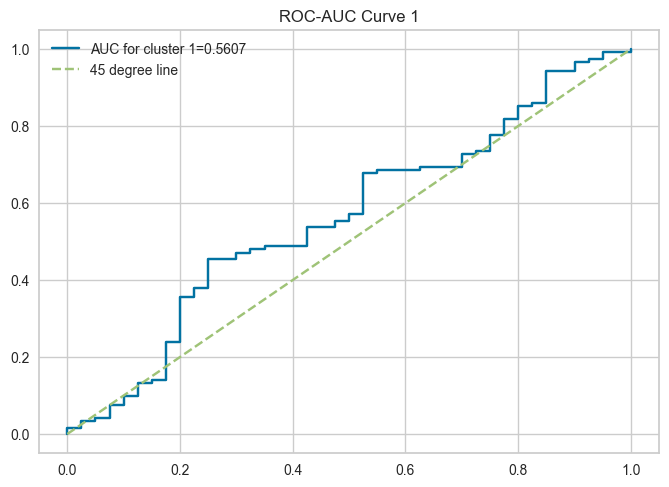

In [33]:
false_pos, true_pos, _= roc_curve(y_test1.values, pred_prob1)
auc = roc_auc_score(y_test1, pred_prob1) 
plt.plot(false_pos,true_pos, label="AUC for cluster 1={:.4f} "
                  .format(auc))
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve 1')
plt.show()

In [34]:
X_train2 = second_cluster_train
y_train2 = y_train[y_train.Clusters == 1]['Risk']
logit = sm.Logit(y_train2, X_train2)
logit_fit2 = logit.fit()
print(logit_fit2.summary())

Optimization terminated successfully.
         Current function value: 0.687315
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  210
Model:                          Logit   Df Residuals:                      206
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:               -0.004506
Time:                        09:43:58   Log-Likelihood:                -144.34
converged:                       True   LL-Null:                       -143.69
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               0.0045      0.144      0.031      0.975      -0.278       0.287
Job               0.

In [35]:
X_test2 = second_cluster_test
y_test2 = y_test[y_test.Clusters == 1]['Risk']
pred_prob2 = logit_fit2.predict(X_test2)

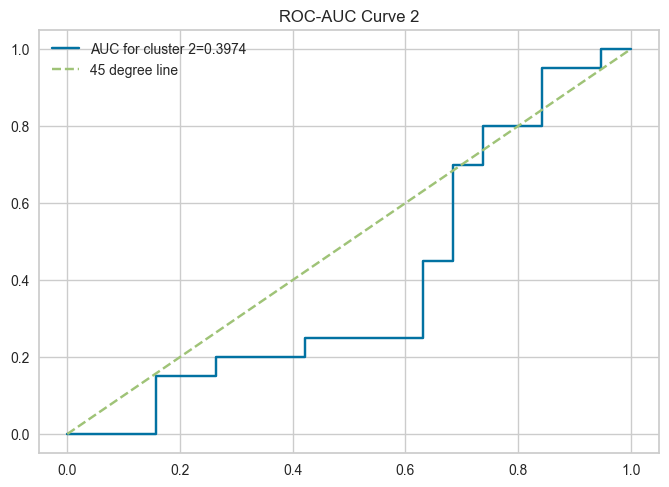

In [36]:
false_pos, true_pos, _ = roc_curve(y_test2.values,  pred_prob2)
auc = roc_auc_score(y_test2, pred_prob2)
plt.plot(false_pos,true_pos,label="AUC for cluster 2={:.4f} ".format(auc))
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve 2')
plt.show()

Support Vector Machines

In [37]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import time

In [40]:
param_svc= {'gamma': [1e-6, 1e-2], 'C':[0.001,.09,1,5,10], 'kernel':('linear','rbf')}

In [41]:
svc= SVC(class_weight='balanced')
halve_SVC= HalvingRandomSearchCV(svc, param_svc, scoring='roc_auc', n_jobs= -1)
halve_SVC.fit(X_train1, y_train1)
print('Best hyperparameters for first cluster in SVC {} with {}'.format(halve_SVC.best_score_, halve_SVC.best_params_))

Best hyperparameters for first cluster in SVC 0.8555512528598184 with {'kernel': 'linear', 'gamma': 1e-06, 'C': 0.09}


In [42]:
y_pred_SVC1= halve_SVC.predict(X_test1)
print('ROC AUC score of SVC for first cluster is {:.4f}'.format(roc_auc_score(y_test1, y_pred_SVC1)))

ROC AUC score of SVC for first cluster is 0.5522


In [43]:
halve_SVC.fit(X_train2, y_train2)
print('Best parameters for second cluster in SVC {} with {}'.format(halve_SVC.best_score_, halve_SVC.best_params_))

Best parameters for second cluster in SVC 0.5939661358294418 with {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}


In [44]:
y_pred_SVC2= halve_SVC.predict(X_test2)
print('THE ROC AUC score of SVC for second cluster is {:.4f}'.format(roc_auc_score(y_test2, y_pred_SVC2)))

THE ROC AUC score of SVC for second cluster is 0.5368


Random Forest -Non parametric models

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rfc= RandomForestClassifier(random_state=42)

In [47]:
param_rfc= {'n_estimators': [100, 300], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [3,4,5,6], 'min_samples_split':[5, 10]}

In [48]:
halve_RF= HalvingRandomSearchCV(rfc, param_rfc, scoring='roc_auc', n_jobs=-1)
halve_RF.fit(X_train1, y_train1)
print('Best hyperparameters for first cluster in RF {} with {}'.
               format(halve_RF.best_score_, halve_RF.best_params_))

Best hyperparameters for first cluster in RF 0.9029117631034106 with {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy'}


In [49]:
y_pred_RF1 = halve_RF.predict(X_test1)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
               format(roc_auc_score(y_test1, y_pred_RF1)))

The ROC AUC score of RF for first cluster is 0.5686


In [50]:
halve_RF.fit(X_train2, y_train2)
print('Best hyperparameters for second cluster in RF {} with {}'.format(halve_RF.best_score_, halve_RF.best_params_))

Best hyperparameters for second cluster in RF 0.7114318414408993 with {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini'}


In [51]:
y_pred_RF2 = halve_RF.predict(X_test2)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
               format(roc_auc_score(y_test2, y_pred_RF2)))

The ROC AUC score of RF for first cluster is 0.5592
